In [ ]:
!pip install folium

In [ ]:
!pip install -U googlemaps

In [ ]:
import googlemaps
import pandas as pd
import csv
import re
import folium
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import plotly.graph_objects as go
import plotly.express as px
import geopandas as gpd
from matplotlib.ticker import MaxNLocator
from google.colab import drive
from shapely.geometry import Point, shape
from urllib.request import urlopen
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
def set_seaborn_style(font_family, background_color, grid_color, text_color):
    sns.set_style({
        "axes.facecolor": background_color,
        "figure.facecolor": background_color,

        "grid.color": grid_color,
        "axes.edgecolor": grid_color,
        "axes.grid": True,
        "axes.axisbelow": True,

        "axes.labelcolor": text_color,
        "text.color": text_color,
        #"font.family": font_family,
        "xtick.color": text_color,
        "ytick.color": text_color,

        "xtick.bottom": False,
        "xtick.top": False,
        "ytick.left": False,
        "ytick.right": False,

        "axes.spines.left": False,
        "axes.spines.bottom": True,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

background_color = "#2F195F"
grid_color = "#582FB1"
bar_color = "#835ED4"
text_color = "#eee"

set_seaborn_style('PT Mono', background_color, grid_color, text_color)

In [ ]:
cols = ['location/lat', 'location/lng', 'roomType', 'numberOfGuests', 'price','reviews', 'lang_1','lang_2','lang_3','stars', 'location_popularity']
df_odesa = pd.read_csv('/content/gdrive/MyDrive/Airbnb explore/data.csv', usecols=cols)
df_odesa = df_odesa.rename(columns = {'location/lat' : 'loc_lat', 'location/lng' : 'loc_lng', 'roomType' : 'room_type', 'numberOfGuests' : 'number_of_guests'})

In [ ]:
display(df_odesa.shape)
display(df_odesa.isna().sum())
df_odesa.head()

In [ ]:
display(df_odesa.drop(columns=['loc_lat', 'loc_lng']).describe().style.format(precision=0, thousands=","))

In [ ]:
room_types = pd.CategoricalDtype(df_odesa['room_type'].unique())
lang_types = pd.CategoricalDtype(set(pd.concat([df_odesa['lang_1'], df_odesa['lang_2'], df_odesa['lang_3']]).dropna()))

df_odesa['room_type'] = df_odesa.loc[:,'room_type'].astype(room_types)
df_odesa['lang_1'] = df_odesa.loc[:,'lang_1'].astype(lang_types)
df_odesa['lang_2'] = df_odesa.loc[:,'lang_2'].astype(lang_types)
df_odesa['lang_3'] = df_odesa.loc[:,'lang_3'].astype(lang_types)

In [ ]:
df_odesa = df_odesa[["price", "loc_lat", "loc_lng"]].dropna()

In [ ]:
df_odesa['reviews'] = df_odesa['reviews'].str.extract('(\d+)').dropna().astype(int)

In [ ]:
df_odesa.info()

# Вплив місткості на ціноутворення

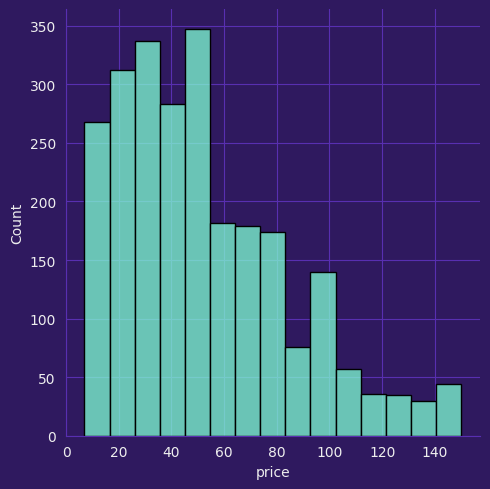

In [ ]:
sns.displot(df_odesa, x='price', bins=15, color='aquamarine')
plt.show()

In [ ]:
colors = sns.color_palette("viridis", len(df_odesa['number_of_guests'].value_counts()))
capacity = df_odesa['number_of_guests'].value_counts().sort_index()

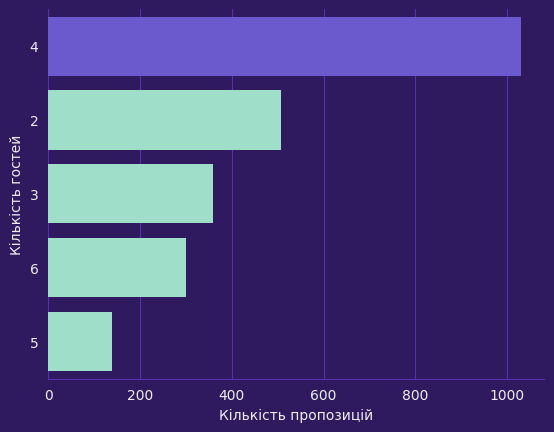

In [ ]:
ax = sns.countplot(df_odesa, y='number_of_guests', order=df_odesa['number_of_guests'].value_counts().iloc[:5].index, color='aquamarine', saturation=0.5)

patch_h = [patch.get_height() for patch in ax.patches]
idx_tallest = np.argmax(patch_h)
ax.patches[idx_tallest].set_facecolor('slateblue')

ax.set_ylabel('Кількість гостей')
ax.set_xlabel('Кількість пропозицій')

plt.show()

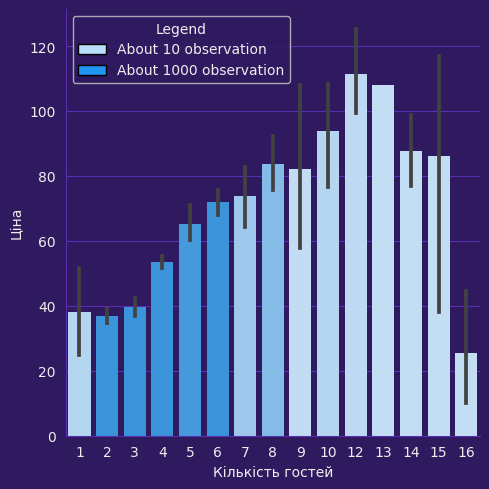

In [ ]:
colours = ["#bbdefb", "#2196f3"]

cmap = mpl.colors.LinearSegmentedColormap.from_list("colour_map", colours, N=256)
norm = mpl.colors.Normalize(df_odesa['price'].min(), df_odesa['price'].max())

g = sns.catplot(data=df_odesa, x="number_of_guests", y="price",kind='bar', palette=cmap(norm(capacity)))
g.axes[0,0].set_xlabel('Кількість гостей')
g.axes[0,0].set_ylabel('Ціна')

colors = ["#bbdefb", "#2196f3"]

values = ["About 10 observation", "About 1000 observation"]

handles = [plt.Rectangle((0,0),1,1, color=colors[i], ec="k") for i in range(len(values))]

plt.legend(handles, values, title="Legend")

plt.show()

# Які типи помешкань найбільш популярні?

In [ ]:
to_ukranian = {'Entire rental unit' : 'Помешкання цілком', 'Entire home' : 'Приватний будинок', 'Entire serviced apartment' : 'Апартаменти від бізнесу/готель',
               'Entire condo' : 'Оренда на двох ', 'Private room in rental unit' : 'Окрема кімната', 'Entire guest suite' : 'Цілий номер для гостей',
               'Entire loft' : 'Лофт', 'Entire guesthouse' : 'Пансіонат', 'Entire townhouse' : 'Таунхаус', 'Private room in guest suite' : 'Окрема кімната в гостьовому номері'}

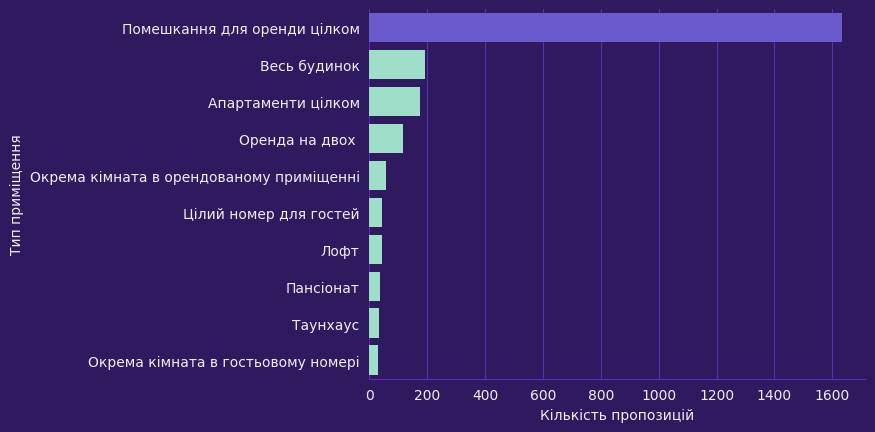

In [ ]:
df_odesa = df_odesa.replace({'room_type' : to_ukranian})
ax = sns.countplot(df_odesa, y='room_type', order=df_odesa['room_type'].value_counts().iloc[:10].index, color='aquamarine', saturation=0.5)

patch_h = [patch.get_height() for patch in ax.patches]
idx_tallest = np.argmax(patch_h)
ax.patches[idx_tallest].set_facecolor('slateblue')

ax.set_ylabel('Тип приміщення')
ax.set_xlabel('Кількість пропозицій')

plt.show()

# Які мови найбільш популярні серед орендодавців?

In [ ]:
lang_translate = {'Русский' : 'Російська',
                  'English': 'Англійська',
                  'Українська' : 'Українська',
                  'Français' : 'Французська',
                  'Italiano' : 'Італійська',
                  'Deutsch' : 'Німецька',
                  'Polski' : 'Польска',
                  'Ελληνικά' : 'Грецька',
                  '中文 (简体)' : 'Китайська',
                  'العربية' : 'Арабська',
                  'беларуская мова' : 'Білоруська',
                  'עברית' : 'Івріт',
                  'Nederlands' : 'Голандська',
                  'Türkçe' : 'Турецька',
                  '日本語' : 'Японська',
                  'हिन्दी' : 'Хінді',
                  'Norsk' : 'Норвезька',
                  'Português' : 'Португальська',
                  'Magyar' : 'Угорська',
                  'Español' : 'Іспанська'
                  }

In [ ]:
df_odesa = df_odesa.replace({'lang_1' : lang_translate, 'lang_2' : lang_translate, 'lang_3' : lang_translate})

In [ ]:
melt = pd.melt(df_odesa[['lang_1','lang_2','lang_3']])

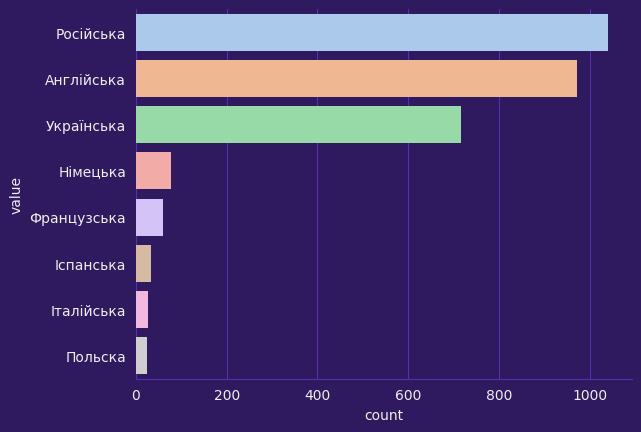

In [ ]:
sns.countplot(melt, y='value', order=melt['value'].value_counts().iloc[:8].index, palette='pastel')
plt.show()

# Рейтинг і кількість відгуків

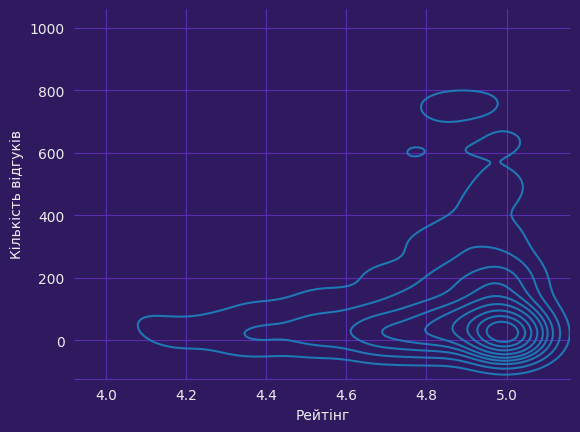

In [ ]:
g = sns.kdeplot(data=df_odesa[df_odesa['reviews'].notna() & df_odesa['stars'].notna() & (df_odesa['stars'] > 4)], x='stars', y='reviews')
g.set_xlabel('Рейтінг')
g.set_ylabel('Кількість відгуків')
plt.show()

# Розподіл цін залежно від району міста

In [ ]:
with open('/content/gdrive/MyDrive/Airbnb explore/map.geojson') as f:
    geojson_data = json.load(f)

def find_territory(row):
    point = Point(row['loc_lng'], row['loc_lat'])
    for feature in geojson_data['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['territory_id']
    return None

df_odesa['territory_id'] = df_odesa.apply(find_territory, axis=1)


In [ ]:
t = df_odesa.groupby('territory_id')['price'].median()

In [ ]:
t.to_frame().reset_index()

,territory_id,price
0,0.0,50.0
1,1.0,31.0
2,2.0,60.0
3,3.0,60.0
4,4.0,45.0
5,5.0,34.5
6,6.0,22.0
7,7.0,30.0
8,8.0,25.0
9,9.0,40.0


In [ ]:
df = df_odesa
geojson = geojson_data
gdf = (
    gpd.GeoDataFrame.from_features(geojson)
    .merge(t.to_frame().reset_index(), on="territory_id")
    .assign(lat=lambda d: d.geometry.centroid.y, lon=lambda d: d.geometry.centroid.x)
    .set_index("territory_id", drop=False)
)

In [ ]:
def basemap():
    fig = px.choropleth_mapbox(t.to_frame().reset_index(),
                               geojson=geojson_data,
                               locations = 'territory_id', color='price',
                               featureidkey="properties.territory_id",
                               color_continuous_scale='viridis',
                            mapbox_style="mapbox://styles/mapbox/streets-v12",
                            zoom=10,
                               opacity=0.5,
                               hover_name=None,
                               center = {"lat": 46.433542, "lon": 30.730276}
                            )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, mapbox={"accesstoken":'pk.eyJ1IjoiZnJvbW9kZXNhIiwiYSI6ImNsaTdvOHRhcjNubHEzcW50MWJiZGY4NzUifQ.wvFjVGUzE8TTzFKnR5mjLw'})
    return fig

In [ ]:
texttrace = go.Scattermapbox(
        lat=gdf.geometry.centroid.y,
        lon=gdf.geometry.centroid.x,
        text=gdf["price"].astype(str) + '$',
        textfont={"color":"white","size":20, "family":"Courier New"},
        mode="text"
    )

basemap().add_trace(texttrace)